In [1]:
import pandas as pd
from tqdm import tqdm
import regex as re
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk import sent_tokenize, word_tokenize

In [2]:
df = pd.read_csv("../data/labeledTrainData.tsv", sep='\t')
len(df)

25000

In [175]:
words = ['dont', 'waste', 'time']
allowed = {'JJ', 'RB'}

tags = nltk.pos_tag(words)
print(tags)
a = list(filter(lambda x: x[1] in allowed, tags))
fwords, ftags = zip(*a)
print(fwords)
print(ftags)

[('dont', 'JJ'), ('waste', 'NN'), ('time', 'NN')]
('dont',)
('JJ',)


In [4]:
all_grams = []
allowed_tags = {'JJ', 'JJ NN', 'JJ NNS', 'JJ NN NN', 'RB JJ NN', 'JJ TO VB', 'VB JJ NN'}
banned_words = {'', 'br'}

def filter_banned_words(words, banned_words):
    filtered_words = list(filter(lambda x: x not in banned_words, words))
    
    return filtered_words

def merge_n_grams(ngrams, ntags):
    merged_n_grams = []
    merged_n_tags = []
    
    for ngram, ntag in zip(ngrams, ntags):
        merged_n_grams.append(' '.join(ngram))
        merged_n_tags.append(' '.join(ntag))
        
    return merged_n_grams, merged_n_tags

def filter_by_tags(ngrams, ntags, allowed_tags):
    pos = zip(ngrams, ntags)
    
    filtered_pos = list(filter(lambda x: len(x[0]) > 1 and x[1] in allowed_tags, pos))
    
    # filtered tags and words
    filtered_words = [word for word, tag in filtered_pos]
    filtered_tags = [tag for word, tag in filtered_pos]
    
    return filtered_words, filtered_tags

def generate_words_and_tags(review):
    sentences = sent_tokenize(review)
    
    # pos tagging and filtering
    pos_tags = []
    for sentence in sentences:
        split_words = [re.sub(r"\p{P}+", "", x).lower() for x in sentence.split()]
        words = filter_banned_words(split_words, banned_words)
        pos_tags.extend(nltk.pos_tag(words))
    
    # split words and tags
    words = [word.lower() for word, tag in pos_tags]
    tags = [tag for word, tag in pos_tags]
    
    return words, tags

def generate_n_grams(words, tags, n=1):
    if n == 1:
        ngrams, ntags = filter_by_tags(words, tags, allowed_tags)
    elif n == 2:
        bigrams = zip(words, words[1:])
        bitags = zip(tags, tags[1:])
        
        mbigrams, mbitags = merge_n_grams(bigrams, bitags)
        ngrams, ntags = filter_by_tags(mbigrams, mbitags, allowed_tags)
    elif n == 3:
        trigrams = zip(words, words[1:], words[2:])
        tritags = zip(tags, tags[1:], tags[2:])

        mtrigrams, mtritags = merge_n_grams(trigrams, tritags)
        ngrams, ntags = filter_by_tags(mtrigrams, mtritags, allowed_tags)
    
    return ngrams, ntags

In [5]:
unigrams = []
bigrams = []
trigrams = []
all_grams = []

for i in tqdm(range(len(df))):
    words, tags = generate_words_and_tags(df.iloc[i]['review'])
    
    unigrams.extend(generate_n_grams(words, tags, 1)[0])
    bigrams.extend(generate_n_grams(words, tags, 2)[0])
    trigrams.extend(generate_n_grams(words, tags, 3)[0])

100%|██████████| 25000/25000 [08:46<00:00, 47.47it/s]


In [6]:
print(len(unigrams))
print(len(bigrams))
print(len(trigrams))

539649
331324
81638


In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

1764


Text(0.5,0,'Unigram counts')

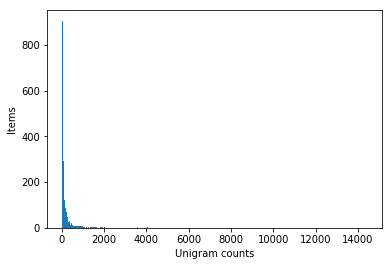

In [8]:
unigram_counts = [x for x in list(Counter(unigrams).values()) if x > 30]
print(len(unigram_counts))
plt.hist(unigram_counts, bins=300)
plt.ylabel('Items')
plt.xlabel('Unigram counts')

6246


Text(0.5,0,'Bigram counts')

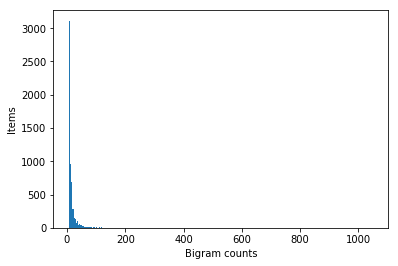

In [9]:
bigram_counts = [x for x in list(Counter(bigrams).values()) if x > 5]
print(len(bigram_counts))
plt.hist(bigram_counts, bins=300)
plt.ylabel('Items')
plt.xlabel('Bigram counts')

1700


Text(0.5,0,'Trigram counts')

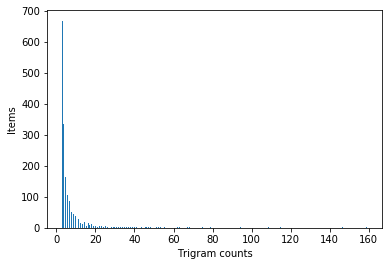

In [10]:
trigram_counts = [x for x in list(Counter(trigrams).values()) if x > 2]
print(len(trigram_counts))
plt.hist(trigram_counts, bins=300)
plt.ylabel('Items')
plt.xlabel('Trigram counts')

In [11]:
allowed_unigrams = {word : count for word, count in list(Counter(unigrams).items()) if count > 30}
allowed_bigrams = {word : count for word, count in list(Counter(bigrams).items()) if count > 5}
allowed_trigrams = {word : count for word, count in list(Counter(trigrams).items()) if count > 2}

filtered_unigrams = [x for x in unigrams if x in allowed_unigrams]
filtered_bigrams = [x for x in bigrams if x in allowed_bigrams]
filtered_trigrams = [x for x in trigrams if x in allowed_trigrams]

all_grams = []
all_grams.extend(filtered_unigrams)
all_grams.extend(filtered_bigrams)
all_grams.extend(filtered_trigrams)

In [12]:
from collections import Counter

counts = Counter(all_grams)

In [13]:
counts.most_common(5000)

[('good', 14415),
 ('other', 8911),
 ('bad', 8886),
 ('great', 8841),
 ('first', 6641),
 ('many', 6575),
 ('<br', 5990),
 ('little', 5869),
 ('much', 5810),
 ('real', 4508),
 ('new', 4225),
 ('such', 4164),
 ('few', 4044),
 ('old', 4019),
 ('same', 4002),
 ('><br', 3625),
 ('young', 3582),
 ('funny', 3426),
 ('big', 3325),
 ('original', 3264),
 ('only', 3202),
 ('own', 3125),
 ('last', 2877),
 ('whole', 2771),
 ('ive', 2553),
 ('different', 2341),
 ('main', 2248),
 ('true', 2224),
 ('interesting', 2157),
 ('hard', 2020),
 ('american', 2018),
 ('special', 2014),
 ('beautiful', 1956),
 ('sure', 1922),
 ('excellent', 1905),
 ('nice', 1888),
 ('black', 1862),
 ('high', 1859),
 ('long', 1829),
 ('poor', 1826),
 ('second', 1682),
 ('short', 1645),
 ('wrong', 1617),
 ('full', 1617),
 ('dead', 1594),
 ('classic', 1579),
 ('small', 1574),
 ('terrible', 1561),
 ('wonderful', 1554),
 ('stupid', 1539),
 ('next', 1502),
 ('awful', 1481),
 ('entire', 1459),
 ('human', 1430),
 ('>the', 1412),
 ('seve

In [14]:
counts.most_common()[-100:]

[('ready to write', 3),
 ('really cool zombie', 3),
 ('lazy sunday afternoon', 3),
 ('not much dialogue', 3),
 ('very different way', 3),
 ('unable to explain', 3),
 ('just enough money', 3),
 ('very funny<br ><br', 3),
 ('really good action', 3),
 ('sad to watch', 3),
 ('first horror movie', 3),
 ('very sad story', 3),
 ('perfect family film', 3),
 ('wong kar wai', 3),
 ('many horror film', 3),
 ('rare blood type', 3),
 ('guilty to be', 3),
 ('very little variation', 3),
 ('once again<br ><br', 3),
 ('other vampire movie', 3),
 ('horrible movie experience', 3),
 ('willing to work', 3),
 ('hard to deny', 3),
 ('numerous to list', 3),
 ('good b movie', 3),
 ('modern film noir', 3),
 ('low budget work', 3),
 ('able to project', 3),
 ('very talented actress', 3),
 ('necessary to tell', 3),
 ('ill admit i', 3),
 ('entire world<br ><br', 3),
 ('willing to settle', 3),
 ('real estate office', 3),
 ('ready to watch', 3),
 ('ready to do', 3),
 ('good way<br ><br', 3),
 ('young scarlett johanss

In [15]:
DIRECTORY = '/mnt/c/Users/gvs/ubuntu/neural-review-summarization/output/'
FILE_NAME = 'important_phrases.csv'
UNIGRAMS_FILE = 'unigrams.csv'
BIGRAMS_FILE = 'bigrams.csv'
TRIGRAMS_FILE = 'trigrams.csv'

In [16]:
n_gram_counts = [Counter(filtered_unigrams), Counter(filtered_bigrams), Counter(filtered_trigrams)]
N_GRAM_FILES = [UNIGRAMS_FILE, BIGRAMS_FILE, TRIGRAMS_FILE]

In [17]:
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df = df.rename(columns={'index':'Phrase', 0:'Count'})

In [18]:
df.to_csv(DIRECTORY + FILE_NAME, encoding='utf-8')

In [19]:
for i in range(len(N_GRAM_FILES)):
    n_gram_file = N_GRAM_FILES[i]
    n_gram_count = n_gram_counts[i]
    
    n_gram_df = pd.DataFrame.from_dict(n_gram_count, orient='index').reset_index()
    n_gram_df = n_gram_df.rename(columns={'index':'Phrase', 0:'Count'})
    n_gram_df.to_csv(DIRECTORY + n_gram_file, encoding='utf-8')    

In [20]:
df = pd.read_csv(DIRECTORY + FILE_NAME)
unigram_df = pd.read_csv(DIRECTORY + UNIGRAMS_FILE)
bigram_df = pd.read_csv(DIRECTORY + BIGRAMS_FILE)
trigram_df = pd.read_csv(DIRECTORY + TRIGRAMS_FILE)

In [21]:
import numpy as np

def load_glove_model(glove_file):
    print("Loading Glove Model")
    with open(glove_file,'r') as f:
        model = {}
        for line in tqdm(f):
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
            
    print("Done.",len(model)," words loaded!")
    return model

In [22]:
GLOVE_DIR = '/home/gvs/neural-review-summarization/model/embeddings/'
GLOVE_FILE = 'glove.6B.300d.txt'
glove = load_glove_model(GLOVE_DIR + GLOVE_FILE)

698it [00:00, 6978.18it/s]

Loading Glove Model


400000it [00:59, 6724.44it/s]

Done. 400000  words loaded!


In [23]:
from sklearn.preprocessing import normalize

def vectorize_phrase(string_phrase, emb_size=300):
    emb_sum = None
    keys = string_phrase.split()
    
    all_in_glove = True
    
    for key in keys:
        if key not in glove:
            all_in_glove = False
            break
    
    if all_in_glove:
        emb_sum = np.zeros(emb_size)
        
        for key in keys:
            vec = glove[key]
            emb_sum += vec

        emb_sum /= len(keys)
        emb_sum = normalize(emb_sum[:,np.newaxis], axis=0).ravel()
    
        """
        norm = np.linalg.norm(emb_sum)
        if norm!=0:
            emb_sum /= np.linalg.norm(norm)
        """
    
    return emb_sum
    
emb_size = len(glove['hi'])

def generate_phrase_meanings(df, emb_size=300):
    meanings = []
    meaning_labels = []
    for i in tqdm(range(len(df))):    
        string_phrase =  df.iloc[i]['Phrase']

        vectorized_phrase = vectorize_phrase(string_phrase, emb_size=emb_size)

        if vectorized_phrase is not None:
            meaning_labels.append(string_phrase)
            meanings.append(vectorized_phrase)
    
    return meanings, meaning_labels

In [24]:
meanings, meaning_labels = generate_phrase_meanings(df, emb_size=emb_size)
uni_meanings, uni_meaning_labels = generate_phrase_meanings(unigram_df, emb_size=emb_size)
bi_meanings, bi_meaning_labels = generate_phrase_meanings(bigram_df, emb_size=emb_size)
tri_meanings, tri_meaning_labels = generate_phrase_meanings(trigram_df, emb_size=emb_size)

100%|██████████| 1700/1700 [00:00<00:00, 2729.79it/s]


In [26]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial

first_example = 0
second_example = 4
print(df.iloc[first_example])
print(df.iloc[second_example])

print(1 - spatial.distance.cosine(meanings[first_example], meanings[second_example]))

Unnamed: 0            0
Phrase        close ups
Count                22
Name: 0, dtype: object
Unnamed: 0             4
Phrase        box office
Count                 17
Name: 4, dtype: object
0.331960795952


In [27]:
print(len(meanings))
print(len(uni_meanings))
print(len(bi_meanings))
print(len(tri_meanings))

9307
1693
6002
1612


In [28]:
meanings_matrix = 1 - cosine_distances(bi_meanings)

In [29]:
meanings_matrix[0][0]

1.0

In [30]:
from sklearn import cluster

def cluster_meanings(meanings):
    #k = 300
    #cl = cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average')
    #cl = cluster.KMeans(n_clusters=k, max_iter=300, n_init=25, n_jobs=2, verbose=1)
    #cl = cluster.DBSCAN(algorithm='auto', eps=0.2, leaf_size=20, min_samples=3, metric='cosine')
    cl = cluster.AffinityPropagation(damping=0.9, max_iter=2000, convergence_iter=1000, preference=None, affinity='precomputed', verbose=True)
    cl.fit_predict(meanings_matrix)
    
    return cl

In [40]:
cl = cluster_meanings(bi_meanings)

Converged after 1289 iterations.


In [42]:
labels = cl.labels_
k = len(list(set(labels)))
print(k)
print(len(labels))
print(len(meaning_labels))

572
6002
9307


In [46]:
def print_phrase_and_clusters(phrases, cluster_labels, show=1000):
    for i in range(show):
        print(phrases[i], cluster_labels[i])
        
def generate_cluster_examples(meaning_labels, cluster_labels):
    cluster_examples = {}

    for i in range(len(cluster_labels)):
        if cluster_labels[i] not in cluster_examples:
            cluster_examples[cluster_labels[i]] = []

        cluster_examples[cluster_labels[i]].append(meaning_labels[i])
        
    return cluster_examples
        
def print_clusters_examples(cluster_examples, cluster_counts, k, show=30):
    for pair in cluster_counts.most_common(k):
        cluster_label, _ = pair

        print("\nPrinting examples for cluster {}:".format(cluster_label))

        size = min(show, len(cluster_examples[cluster_label]))
        for i in range(size):
            print(cluster_examples[cluster_label][i])

In [47]:
cluster_counts = Counter(labels)
print(cluster_counts.most_common(k))

cluster_examples = generate_cluster_examples(bi_meaning_labels, labels)

print_clusters_examples(cluster_examples, cluster_counts, k)

[(516, 71), (487, 54), (445, 53), (207, 46), (455, 46), (1, 42), (170, 41), (28, 39), (84, 39), (254, 39), (499, 38), (133, 37), (297, 37), (153, 36), (275, 36), (309, 36), (535, 35), (425, 34), (467, 33), (131, 32), (233, 32), (245, 32), (50, 31), (88, 31), (464, 31), (522, 30), (169, 29), (269, 29), (302, 29), (520, 29), (542, 29), (24, 28), (195, 28), (341, 28), (29, 27), (93, 27), (103, 27), (130, 27), (370, 27), (381, 27), (26, 26), (296, 26), (139, 25), (300, 25), (306, 25), (318, 25), (14, 24), (333, 24), (359, 24), (435, 24), (449, 24), (532, 24), (45, 23), (59, 23), (158, 23), (277, 23), (310, 23), (349, 23), (433, 23), (497, 23), (549, 23), (570, 23), (260, 22), (312, 22), (490, 22), (68, 21), (76, 21), (257, 21), (319, 21), (394, 21), (432, 21), (122, 20), (126, 20), (162, 20), (217, 20), (226, 20), (424, 20), (429, 20), (496, 20), (509, 20), (528, 20), (55, 19), (80, 19), (89, 19), (305, 19), (320, 19), (323, 19), (331, 19), (392, 19), (6, 18), (22, 18), (64, 18), (69, 18),

last years
last moment
last wave
previous year
same year
last part
last picture
last couple
last command
last week
next year
last section
last hunt
new year
last summer
last weekend
last forever
last case
ten year
last half

Printing examples for cluster 88:
only scene
entire scene
famous scene
whole scene
last scene
dramatic scene
single scene
same scene
climactic scene
little scene
new scene
early scene
first scene
opening scene
key scene
particular scene
next scene
short scene
final scene
good scene
long scene
ridiculous scene
wonderful scene
love scene
second scene
last sequence
other scene
fight scene
great scene
disturbing scene

Printing examples for cluster 464:
real friends
real winner
real masterpiece
real men
real i
real event
real shame
real reason
real way
real gem
real scares
real treat
real deal
real talent
real life
real surprise
real hero
real person
real heroes
real problem
real standout
real estate
real stinker
real time
real mystery
real villain
real thing
real chan

wide screen
screen play
small screen
screen time
blue screen
black screen
much screen
blank check
screen presence
full screen
limited screen
screen test

Printing examples for cluster 351:
final scenes
erotic scenes
interesting scenes
hilarious scenes
deleted scenes
scary scenes
beautiful scenes
graphic scenes
memorable scene
memorable quotes
memorable performances
memorable scenes
nice scenes
memorable characters
spectacular scenes
dramatic scenes

Printing examples for cluster 356:
slow start
snappy pace
fast pace
reasonable pace
snails pace
slow moving
slow pace
steady pace
nice pace
slow boring
slow paced
slow pacing
downward spiral
slow motion
quick pace
good pace

Printing examples for cluster 361:
other men
other couples
different men
different women
hard men
leading ladies
many men
black women
sexy women
other women
other woman
attractive women
many women
japanese women
other girls
hot women

Printing examples for cluster 427:
bad comedy
entertaining comedy
good humor
black com

grand prix
grand finale
duke ellington
grand duke
grand canyon

Printing examples for cluster 266:
chinese culture
recent history
chinese history
russian roulette
chinese ghost
japanese history

Printing examples for cluster 268:
dead mans
poor mans
old mans
young mans
mans life
white mans

Printing examples for cluster 285:
national lampoons
national treasure
national geographic
national security
national anthem
national lampoon

Printing examples for cluster 289:
loyal fan
longtime fan
avid fan
dedicated fan
true fan
avid reader

Printing examples for cluster 315:
asian film
asian cinema
asian actors
asian horror
local cinema
european cinema

Printing examples for cluster 353:
great voice
singing voice
own voice
same voice
good voice
original voice

Printing examples for cluster 363:
good camera
poor camera
interesting camera
bad camera
great camera
shaky camera

Printing examples for cluster 374:
true gem
rare example
underrated gem
rare treat
little gem
rare gem

Printing examples 

In [65]:
print_phrase_and_clusters(bi_meaning_labels, labels)

close ups 258
faithful adaptation 441
id heard 488
difficult time 126
box office 188
real friends 464
dry eye 141
central performance 108
different people 341
same tone 0
new kind 1
straight face 216
timothy hines 163
baby face 216
worst movie 570
chronological order 262
back seat 173
technical side 407
doesnt matter 569
lex luthor 2
good kind 170
second class 131
favourite actors 236
bad ass 547
only scene 88
first guy 260
public domain 442
southern drawl 118
napoleon dynamite 3
total mess 447
sexual assault 226
fantastic i 542
wonderful characters 275
second renaissance 131
last quarter 50
dramatic actor 193
real depth 331
silent screen 377
mysterious woman 176
major star 57
black riders 302
prashant raj 325
20th century 273
american society 29
next week 296
african americans 29
key moments 253
first version 14
last house 203
worst movies 570
true meaning 36
physical contact 114
jon voight 73
redeeming qualities 142
gus van 4
columbo movie 245
daily life 530
technical level 93
old wo

In [66]:
DIRECTORY = '/mnt/c/Users/gvs/ubuntu/neural-review-summarization/model/'
KMEANS_MODEL_FILE = "k_means_model.pkl"

In [88]:
PHRASE_KEY = 'Phrase'
LABEL_KEY = 'Label'
LIST_ID_KEY = 'List Id'
AFFINITY_CLUSTER_CENTERS = 'cluster_centers.csv'
AFFINITY_CLUSTER_LABELS = 'phrase_cluster_labels.csv'

def save_affinity_model(meaning_labels, labels, cluster_center_indices, directory, cluster_centers_file, cluster_labels_file):
    phrase_cluster_labels_df = pd.DataFrame(list(zip(bi_meaning_labels, labels)), columns=[PHRASE_KEY, LABEL_KEY])
    cluster_centers = [(center, bi_meaning_labels[center], labels[center]) for center in cl.cluster_centers_indices_]
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=[LIST_ID_KEY, PHRASE_KEY, LABEL_KEY])
    
    phrase_cluster_labels_df.to_csv(directory + cluster_labels_file, encoding='utf-8', index=False)
    cluster_centers_df.to_csv(directory + cluster_centers_file, encoding='utf-8', index=False)
    
    return phrase_cluster_labels_df, cluster_centers_df

In [89]:
import pickle

phrase_cluster_labels_df, cluster_centers_df = save_affinity_model(bi_meaning_labels, labels, cl.cluster_centers_indices_, 
                                                                   DIRECTORY, AFFINITY_CLUSTER_CENTERS, AFFINITY_CLUSTER_LABELS)

"""
with open(DIRECTORY + AFFINITY_MODEL_FILE, 'wb') as model_file:
    pickle.dump(cl, model_file, protocol=pickle.HIGHEST_PROTOCOL)
    print('model saved')
"""

"\nwith open(DIRECTORY + AFFINITY_MODEL_FILE, 'wb') as model_file:\n    pickle.dump(cl, model_file, protocol=pickle.HIGHEST_PROTOCOL)\n    print('model saved')\n"

In [90]:
phrase_cluster_labels_df = pd.read_csv(DIRECTORY + AFFINITY_CLUSTER_LABELS)
cluster_centers_df = pd.read_csv(DIRECTORY + AFFINITY_CLUSTER_CENTERS)

In [142]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(metric='cosine').fit(np.array(all_cluster_center_meanings))
#neigh.kneighbors([vectorize_phrase("great movie", emb_size=emb_size)], return_distance=False)

array([[320, 269, 297,   5,  28]])

In [139]:
all_cluster_centers = list(cluster_centers_df[PHRASE_KEY])
all_cluster_center_meanings = [vectorize_phrase(cluster_center_phrase, emb_size=emb_size) for cluster_center_phrase in tqdm(all_cluster_centers)]

100%|██████████| 572/572 [00:00<00:00, 3177.88it/s]


In [183]:
test_df = pd.read_csv("../data/test_midnight_cowboy.tsv", sep='\t', encoding='latin-1')

In [184]:
test_unigrams = []
test_bigrams = []
test_trigrams = []

for i in tqdm(range(len(test_df))):
    words, tags = generate_words_and_tags(test_df.iloc[i]['review'])
    
    test_unigrams.extend(generate_n_grams(words, tags, 1)[0])
    test_bigrams.extend(generate_n_grams(words, tags, 2)[0])
    test_trigrams.extend(generate_n_grams(words, tags, 3)[0])

100%|██████████| 80/80 [00:02<00:00, 34.15it/s]


In [185]:
test_counts = Counter(test_bigrams)
print(test_counts.most_common(40))

[('new york', 83), ('joe buck', 13), ('first time', 10), ('main characters', 9), ('dustin hoffman', 8), ('big city', 7), ('big apple', 6), ('great movie', 6), ('academy award', 6), ('old man', 5), ('young man', 5), ('late 1960s', 4), ('late 60s', 4), ('male prostitute', 4), ('psychedelic party', 4), ('main character', 4), ('same way', 4), ('ratso rizzo', 4), ('whole film', 4), ('i dont', 3), ('late sixties', 3), ('simple story', 3), ('new yorkers', 3), ('small town', 3), ('male hustler', 3), ('real world', 3), ('only thing', 3), ('american dream', 3), ('new yorker', 3), ('easy rider', 3), ('naive joe', 3), ('long time', 3), ('other times', 3), ('enough money', 2), ('enrico ratso', 2), ('real cowboy', 2), ('first x', 2), ('fantastic movie', 2), ('few steps', 2), ('xrated film', 2)]


In [186]:
"""
if cl is None:
    with open(DIRECTORY + KMEANS_MODEL_FILE, 'rb') as model_file:
        cl = pickle.load(model_file)
        print('model loaded')
"""

"\nif cl is None:\n    with open(DIRECTORY + KMEANS_MODEL_FILE, 'rb') as model_file:\n        cl = pickle.load(model_file)\n        print('model loaded')\n"

In [187]:
manual_phrases = ['fundamental problems', 'unrelenting tedium', 'most horrible blockbuster']

vectorized_phrases = []
test_labels = []

for phrase in tqdm(test_bigrams):
    vectorized_phrase = vectorize_phrase(phrase)
    if vectorized_phrase is not None:
        vectorized_phrases.append(vectorized_phrase)
        test_labels.append(phrase)

100%|██████████| 1435/1435 [00:00<00:00, 7037.07it/s]


In [188]:
#test_predictions = cl.fit_predict(test_meanings_matrix)
test_predictions = neigh.kneighbors(vectorized_phrases, return_distance=False)[:, 0]
print(test_predictions)

[ 84  84  84 ...,  69 409 435]


In [189]:
Counter(list(test_predictions)).most_common(60)

[(239, 94),
 (226, 17),
 (84, 16),
 (476, 16),
 (513, 16),
 (77, 15),
 (207, 15),
 (435, 15),
 (130, 14),
 (487, 14),
 (131, 13),
 (195, 13),
 (520, 13),
 (306, 12),
 (469, 12),
 (28, 11),
 (29, 11),
 (59, 11),
 (312, 11),
 (329, 11),
 (351, 11),
 (516, 11),
 (383, 10),
 (1, 9),
 (225, 9),
 (269, 9),
 (320, 9),
 (359, 9),
 (384, 9),
 (409, 9),
 (24, 8),
 (26, 8),
 (68, 8),
 (71, 8),
 (76, 8),
 (88, 8),
 (210, 8),
 (277, 8),
 (386, 8),
 (433, 8),
 (464, 8),
 (467, 8),
 (480, 8),
 (528, 8),
 (94, 7),
 (170, 7),
 (217, 7),
 (258, 7),
 (300, 7),
 (410, 7),
 (416, 7),
 (425, 7),
 (499, 7),
 (511, 7),
 (522, 7),
 (547, 7),
 (45, 6),
 (60, 6),
 (190, 6),
 (193, 6)]

In [190]:
good_clusters = {570, 455, 35, 190, 404, 26, 182, 281, 226, 84, 476, 207, 487, 131, 520, 469, 28, 59, 312, 329, 351, 1, 225, 269, 320, 359, 409, 24, 26, 76, 88, 210, 386, 464, 467, }
bad_clusters = {310, 337, 260, 365, 368, 435, 510, 522, 239, 513, 77, 435, 130, 195, 306, 29, 516, 383, 384, 68, 71, 277, 433,}
filtered_labels = []

for i in range(len(test_predictions)):
    test_prediction = test_predictions[i]
    
    if test_prediction in good_clusters:
        filtered_labels.append(test_labels[i])

test_labels_count = Counter(filtered_labels)
print(test_labels_count)

Counter({'first time': 10, 'main characters': 9, 'big apple': 6, 'great movie': 6, 'academy award': 6, 'main character': 4, 'whole film': 4, 'easy rider': 3, 'real world': 3, 'new life': 2, 'unusual theme': 2, 'human beings': 2, 'new world': 2, 'great performances': 2, 'true grit': 2, 'fantastic movie': 2, 'real cowboy': 2, 'big hit': 2, 'good movie': 2, 'fine film': 2, 'outstanding performances': 2, 'sexual revolution': 2, 'solid performances': 1, 'second time': 1, 'fine performances': 1, 'many victims': 1, 'sad film': 1, 'real friends': 1, 'big bucks': 1, 'prevailing theme': 1, 'new society': 1, 'sympathetic handsome': 1, 'insistent theme': 1, 'emotional response': 1, 'sexual perverts': 1, 'unpleasant story': 1, 'incredible movie': 1, 'sexual explicitness': 1, 'strong friendship': 1, 'abuse consumption': 1, 'gritty realities': 1, 'sexual insecurities': 1, 'big fuss': 1, 'wonderful film': 1, 'superb vignettes': 1, 'wonderful performances': 1, 'realistic portrait': 1, 'fellow passenger

In [192]:
clustered_predictions = {}
clustered_predictions_weights = {}

for i in range(len(test_predictions)):
    test_prediction = test_predictions[i]
    
    if test_prediction in good_clusters:
        if test_prediction not in clustered_predictions:
            clustered_predictions[test_prediction] = set()
            clustered_predictions_weights[test_prediction]= 0
        
        clustered_predictions[test_prediction].add(test_labels[i])
        clustered_predictions_weights[test_prediction] += test_labels_count[test_labels[i]]
        
print(clustered_predictions)
print(clustered_predictions_weights)

important_clusters = []
for key in clustered_predictions_weights.keys():
    important_clusters.append((clustered_predictions_weights[key], clustered_predictions[key]))

important_clusters.sort(key=lambda tup: tup[0], reverse=True)

for count, phrase_set in important_clusters:
    print('Printing the cluster with {} mentions'.format(count))
    
    for key in list(phrase_set):
        print(key)
    
    print('')

#print(important_clusters)

{320: {'great films', 'great movie', 'great cinema', 'great adventure'}, 1: {'new clothes', 'new society', 'new knowledge', 'new order', 'new culture', 'new start', 'new life', 'new way'}, 386: {'elusive comfort', 'amorous love', 'true grit', 'true genre', 'true genius', 'true nature', 'powerful love'}, 131: {'second time', 'second thoughts', 'first time', 'second disc'}, 455: {'bad luck', 'bad effect', 'bad guys', 'bad things', 'bad influences'}, 520: {'poignant issue', 'fabulous interpretation', 'interesting trivia', 'compelling story', 'sentimental story', 'discernible story', 'unique story', 'informative commentary', 'sordid storyline', 'depressing story', 'unpleasant story', 'touching story', 'fascinating midnight'}, 329: {'innate innocence', 'mild sympathy', 'strong reputations', 'blunt notion', 'strong bond', 'misguided expectation', 'unwavering sense', 'pervasive cynicism', 'assertive rejection', 'strong focusing', 'strong friendship'}, 76: {'emotional connection', 'traumatic e

In [153]:
kmeans.predict([vectorize_phrase("big apple")])

array([531], dtype=int32)

In [60]:
data_df = pd.DataFrame.from_csv("../data/labeledTrainData.tsv", sep='\t', header=0)

/home/gvs/.virtualenvs/neural-review-summarization/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [83]:
ids = data_df.index.values
print(ids[:10])

split_ids = []
for id in ids:
    split_id = str(id).split('_')
    split_ids.append(split_id[0])
    
id_counts = Counter(split_ids)

print(id_counts.most_common(1000))

['5814_8' '2381_9' '7759_3' '3630_4' '9495_8' '8196_8' '7166_2' '10633_1'
 '319_1' '8713_10']
[('2952', 2), ('3624', 2), ('3848', 2), ('4739', 2), ('12247', 2), ('5328', 2), ('3385', 2), ('8746', 2), ('7776', 2), ('6126', 2), ('12384', 2), ('2267', 2), ('178', 2), ('4250', 2), ('2353', 2), ('5462', 2), ('477', 2), ('2687', 2), ('242', 2), ('2795', 2), ('10482', 2), ('10536', 2), ('2515', 2), ('12344', 2), ('6067', 2), ('6867', 2), ('12219', 2), ('6279', 2), ('8046', 2), ('2790', 2), ('3148', 2), ('6125', 2), ('1501', 2), ('1535', 2), ('2986', 2), ('529', 2), ('3517', 2), ('54', 2), ('162', 2), ('8059', 2), ('7011', 2), ('12472', 2), ('794', 2), ('6077', 2), ('1126', 2), ('7125', 2), ('8944', 2), ('11232', 2), ('5804', 2), ('309', 2), ('8605', 2), ('1433', 2), ('9893', 2), ('7443', 2), ('10591', 2), ('11530', 2), ('9907', 2), ('10974', 2), ('6950', 2), ('7110', 2), ('9515', 2), ('4196', 2), ('10669', 2), ('1457', 2), ('9672', 2), ('5599', 2), ('5021', 2), ('12322', 2), ('5093', 2), ('19

In [247]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
print(kmeans.cluster_centers_.)
for i in range(k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % meaning_labels[ind]),

SyntaxError: invalid syntax (<ipython-input-247-445f186ab7e3>, line 3)

In [173]:
print(1 - spatial.distance.cosine(kmeans.cluster_centers_[187], vectorize_phrase("new artwork")))

0.807326261227


In [164]:
kmeans.cluster_centers_[531]

array([  6.02488181e-03,   4.00078939e-02,  -2.34505436e-03,
        -1.30845203e-02,   5.30984175e-03,   5.20652970e-02,
         1.71046704e-03,   4.12636928e-02,  -2.77371868e-02,
        -1.57973884e-01,  -1.06839710e-02,   1.50319295e-02,
        -1.14223715e-02,   4.48585202e-02,   2.10645142e-02,
        -3.22269700e-02,  -2.67787018e-02,  -3.18474338e-02,
         4.14716724e-02,   1.85291144e-02,   6.45597273e-02,
         8.43474106e-02,   5.18868235e-02,   4.76995949e-02,
        -3.66124305e-02,   3.10804753e-02,   2.36923731e-03,
        -6.51511906e-02,   2.91555910e-02,  -1.70827616e-02,
        -5.21377058e-02,  -3.67795052e-03,  -4.93548017e-02,
         2.18489254e-02,  -2.16898291e-01,   5.39831127e-02,
        -3.73293203e-02,  -1.92715543e-02,  -2.39249771e-02,
         3.08766904e-02,  -7.42926193e-04,  -5.45357351e-02,
         3.26134134e-02,   2.96699381e-02,  -3.82175551e-02,
         2.65053214e-02,   6.40541198e-02,  -5.25016424e-02,
        -1.08542158e-02,